<a href="https://colab.research.google.com/github/nhjung74/paper/blob/main/factor_rl_portfolio_20250702_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 딥러닝 처리 환경 requirements
g_drive = False
mac_gpu = False
# colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
# print(IN_COLAB)

if IN_COLAB:
    print('colab......')
    g_drive = True
    # google drive setting
    #from google.colab import drive
    #drive.mount('/content/drive')
    #import os
    #try:
    #    import transformers, emoji, soynlp, pytorch_lightning
    #except:
    #    ! pip install -U -q transformers emoji soynlp pytorch-lightning snoop wandb sklearn seaborn pandas numpy
    # restart runtime
    #os.kill(os.getpid(), 9)
elif IN_COLAB==False:
    print('not colab')
    g_drive = False
    #import os
    #try:
    #    import transformers, emoji, soynlp, pytorch_lightning
    #except:
    #    ! pip install -U -q transformers emoji soynlp pytorch-lightning snoop wandb sklearn seaborn pandas numpy
    #    ! pip install -q torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

print('g_drive=',g_drive)

colab......
g_drive= True


In [2]:
import platform

platform.system()

'Linux'

In [3]:
os_type = platform.system()

In [4]:
# Os 종류를 확인한다.
if os_type == 'Darwin':
    mac_gpu = True
else:
    mac_gpu = False
print('mac_gpu=',mac_gpu)

mac_gpu= False


In [5]:
if g_drive == True:
  !pip install --upgrade pip

In [6]:
if g_drive == True:
  !pip install PyPortfolioOpt

In [7]:
if g_drive == True:
  !pip install shimmy>=0.2.1

In [8]:
if g_drive == True:
  !pip install stable-baselines3

In [9]:
# 필요한 패키지 불러오기
import os
import math
import time
import datetime

In [10]:
# 기본 디렉토리 설정
if g_drive==False:
    from google.colab import drive
    drive.mount('/content/gdrive')
    base_dir = '/content/gdrive/My Drive/Colab Notebooks/aSSIST/factor_Project'
    data_dir = os.path.join(base_dir, 'data')

    # 디렉토리 생성
    os.makedirs(data_dir, exist_ok=True)

    # 경로 이동
    os.chdir(data_dir)

    # 모델 저장 디렉토리 설정
    MODEL_DIR = data_dir  # 또는 MODEL_DIR = os.getcwd()

    # 경로 확인
    print(f"현재 작업 경로: {os.getcwd()}")
    print(f"모델 저장 경로: {MODEL_DIR}")

In [11]:
start_date ='2019-01-01'
end_date ='2025-06-30'

In [12]:
!ls

'=0.2.1'   df_factors.xlsx   df_price.xlsx   df_returns.xlsx   sample_data


In [13]:
!pwd

/content


# 첫 번째 실험 (PPO + Crypto + Sharpe 보상)

다음 6가지 실험을 한 번에 실행하고 결과를 비교

Crypto_PPO_sharpe

Crypto_PPO_beta

Crypto_SAC_sharpe

Crypto_SAC_beta

Crypto_TD3_sharpe

Crypto_TD3_beta

# 최종소스 20250616

In [14]:
import gym
import numpy as np
import pandas as pd
import yfinance as yf
import shap

import matplotlib.pyplot as plt
from gym import spaces
from stable_baselines3 import PPO, SAC, TD3
from stable_baselines3.common.vec_env import DummyVecEnv
import torch
import random
from sklearn.linear_model import LinearRegression  # 추가
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from scipy.stats import ttest_ind, mannwhitneyu

from pypfopt import expected_returns, risk_models
from pypfopt.efficient_frontier import EfficientFrontier


In [15]:
# Seed 설정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

show_summary = True

In [16]:
# 자산군 설정
# 📁 미국 개별주 (Big Tech + S&P/Dow 종목 중 대표)
stock_assets = [
    "AAPL",  # Apple
    "MSFT",  # Microsoft
    "GOOGL", # Alphabet (Google)
    "AMZN",  # Amazon
    "META",  # Meta (Facebook)
    "TSLA",  # Tesla
    "NVDA",  # Nvidia
    "NFLX",  # Netflix
    "JPM",   # JPMorgan Chase
    "V",     # Visa
    "DIS",   # Disney
    "INTC",  # Intel
    "BA",    # Boeing
    "XOM",   # Exxon Mobil
    "JNJ",   # Johnson & Johnson
    "KO",    # Coca-Cola
    "PG",    # Procter & Gamble
    "WMT",   # Walmart
    "UNH",   # UnitedHealth Group
]

# 📁 ETF (대표지수 ETF)
etf_assets = [
    "SPY",  # S&P 500 ETF
    "QQQ",  # NASDAQ 100 ETF
    "DIA",  # Dow Jones ETF
]

# 📁 해외 주요 개별주 (미국 외 상장 종목)
equity_assets = [
    "BABA", # Alibaba (NYSE)
    "TSM",  # Taiwan Semiconductor (NYSE/TSMC)
]

# 📁 암호화폐 (Crypto Currencies)
crypto_assets = [
    "BTC-USD",  # Bitcoin
    "ETH-USD",  # Ethereum
    "BNB-USD",  # Binance Coin
    "SOL-USD",  # Solana
]


macro_assets = [
    # 채권 및 금리 관련
    "TLT",     # iShares 20+ Year Treasury Bond ETF
    "IEF",     # iShares 7-10 Year Treasury Bond ETF
    "^TNX",    # CBOE 10-Year Treasury Yield Index (미국 10년물 수익률)
    "^IRX",    # CBOE 13-week Treasury Bill Yield

    # 원자재 관련
    "GLD",     # SPDR Gold Shares (금)
    "SLV",     # iShares Silver Trust (은)
    "USO",     # United States Oil Fund (原油)
    "DBB",     # Invesco DB Base Metals Fund (금속)
    "DBC",     # Invesco DB Commodity Index Tracking Fund (종합 원자재)

    # 인플레이션 관련
    "TIP",     # iShares TIPS Bond ETF (물가연동채)
]

# 📁 전체 통합 자산군
#mixed_assets = stock_assets + etf_assets + equity_assets + crypto_assets + macro_assets
#mixed_assets = ["AAPL","MSFT","TSLA","SPY","BTC-USD","TLT","GLD"]
mixed_assets = ["IEF","TLT","GLD"]
#mixed_assets = stock_assets
print(mixed_assets)

['IEF', 'TLT', 'GLD']


In [17]:
def save_model(model, save_path="models", filename="ppo_model.zip"):
    import os
    os.makedirs(save_path, exist_ok=True)
    model.save(os.path.join(save_path, filename))

def load_model(model_class, env, save_path="models", filename="ppo_model.zip"):
    from stable_baselines3.common.vec_env import DummyVecEnv
    return model_class.load(os.path.join(save_path, filename), env=env)


In [18]:
def compare_strategies(series1, series2, label1="A", label2="B"):
    """
    두 포트폴리오 가치 시계열에 대해 t-test와 Mann–Whitney U-test 수행
    """
    returns1 = series1.pct_change().dropna()
    returns2 = series2.pct_change().dropna()

    # 길이 맞추기
    min_len = min(len(returns1), len(returns2))
    returns1 = returns1[-min_len:]
    returns2 = returns2[-min_len:]

    # 평균차이 검정 (t-test)
    t_stat, t_p = ttest_ind(returns1, returns2, equal_var=False)

    # 비모수 검정 (Mann–Whitney U-test)
    u_stat, u_p = mannwhitneyu(returns1, returns2, alternative='two-sided')

    print(f"\n🔎 [{label1} vs {label2}]")
    print(f"▶ t-test p-value: {t_p:.4f} → {'유의미함' if t_p < 0.05 else '유의미하지 않음'}")
    print(f"▶ Mann–Whitney U-test p-value: {u_p:.4f} → {'유의미함' if u_p < 0.05 else '유의미하지 않음'}")

    return {
        "t_p": t_p,
        "u_p": u_p
    }

In [19]:
def compute_rolling_beta(price_data: pd.DataFrame, volume_data: pd.DataFrame, window: int = 60) -> pd.DataFrame:
    log_return = np.log(price_data / price_data.shift(1))
    momentum = price_data.pct_change(20)
    volatility_raw = log_return.rolling(20).std()
    volatility_score = 1 / (1 + volatility_raw)

    ma = price_data.rolling(20).mean()
    ma_deviation = (price_data - ma) / ma

    volume_z_raw = (volume_data - volume_data.rolling(20).mean()) / volume_data.rolling(20).std()
    volume_z_score = 1 / (1 + volume_z_raw.abs())

    beta_data = {}
    asset_list = price_data.columns
    n_assets = len(asset_list)

    for asset in asset_list:
        asset_df = pd.DataFrame({
            "y": log_return[asset],
            "momentum": momentum[asset],
            "volatility": volatility_score[asset],
            "ma_dev": ma_deviation[asset],
            "volume_z": volume_z_score[asset]
        }).dropna()

        betas = []
        index_list = []

        for i in range(window, len(asset_df)):
            y = asset_df["y"].iloc[i - window:i].values
            X = asset_df[["momentum", "volatility", "ma_dev", "volume_z"]].iloc[i - window:i].values
            price_window = price_data[asset].iloc[i - window:i]
            returns = price_window.pct_change().dropna()

            if np.any(np.isnan(X)) or np.any(np.isnan(y)) or returns.empty:
                betas.append([np.nan] * 7)
                index_list.append(asset_df.index[i])
                continue

            reg = LinearRegression().fit(X, y)
            sharpe = returns.mean() / (returns.std() + 1e-6)
            cumulative = (1 + returns).cumprod()
            peak = cumulative.cummax()
            drawdown = (cumulative - peak) / peak
            mdd = drawdown.min()
            beta_mdd = 1 - abs(mdd)

            # EqualWeight 유사도 (가격 기반)
            weights_price = price_data.iloc[i - 1] / price_data.iloc[i - 1].sum()
            eqw = 1 / n_assets
            eqw_similarity_price = 1 - abs(weights_price[asset] - eqw)  # 1에 가까울수록 EW에 유사

            # EqualWeight 유사도 (정책 기반)
            action_t = np.zeros(n_assets)
            action_t[list(price_data.columns).index(asset)] = 1.0  # 단일 자산 투자 가정
            weights_eqw = np.ones(n_assets) / n_assets
            eqw_similarity_policy = 1 - np.linalg.norm(action_t - weights_eqw)

            # 팩터 저장
            betas.append(list(reg.coef_) + [sharpe, beta_mdd, eqw_similarity_price, eqw_similarity_policy])
            index_list.append(asset_df.index[i])

        # 컬럼명을 언더스코어로 변경
        beta_df = pd.DataFrame(
            betas,
            columns=[
                f"{asset}_beta_mom", f"{asset}_beta_vol", f"{asset}_beta_ma", f"{asset}_beta_volz",
                f"{asset}_beta_sharpe", f"{asset}_beta_mdd",
                f"{asset}_beta_eqw_price", f"{asset}_beta_eqw_policy"
            ],
            index=index_list
        )
        beta_data[asset] = beta_df

    beta_panel = pd.concat(beta_data, axis=1)
    #beta_panel.columns = [f"{a}_{b}" for a, b in beta_panel.columns]  # ✅ 여기 추가
    beta_panel.columns = [b for a, b in beta_panel.columns]
    beta_panel.index.name = "Date"
    return beta_panel


In [20]:
# 데이터 수집 함수 (수정: 거래량 데이터 추가 및 베타 통합)
def fetch_data(assets, start=start_date, end=end_date):
    # 전체 데이터 다운로드 (종가 + 거래량)
    data = yf.download(assets, start=start, end=end, auto_adjust=True, progress=False, threads=False)
    price = data["Close"].ffill().bfill().dropna()
    volume = data["Volume"].ffill().bfill().dropna()

    # 기존 팩터 계산
    returns = price.pct_change().dropna()
    momentum = price.pct_change(20).dropna()
    volatility = returns.rolling(20).std().dropna()
    factors = pd.concat([momentum.add_suffix("_mom"), volatility.add_suffix("_vol")], axis=1).dropna()

    # 시간가변 베타 계산 (추가)
    beta_df = compute_rolling_beta(price, volume)

    # 팩터와 베타 통합
    combined_factors = pd.concat([factors, beta_df], axis=1).dropna()

    # 인덱스 정렬
    idx = price.index.intersection(combined_factors.index).intersection(returns.index)

    if show_summary:
        df_price = None
        df_returns = None
        df_factors = None

        # 기술통계 요약 출력
        print("\n[기술통계 요약: Price]")
        print(price.loc[idx].describe().T.round(4))
        df_price = price.loc[idx].describe().T.round(4)
        df_price.to_excel('df_price.xlsx')

        print("\n[기술통계 요약: Returns]")
        print(returns.loc[idx].describe().T.round(4))
        df_returns = returns.loc[idx].describe().T.round(4)
        df_returns.to_excel('df_returns.xlsx')

        print("\n[기술통계 요약: Factors (Momentum, Volatility, Beta 등)]")
        print(combined_factors.loc[idx].describe().T.round(4))
        df_factors = combined_factors.loc[idx].describe().T.round(4)
        df_factors.to_excel('df_factors.xlsx')


    return price.loc[idx], returns.loc[idx], combined_factors.loc[idx]

In [21]:
# 강화학습 환경 (보상 계산 로직 수정: 베타 팩터 활용)
class PPOPortfolioEnv(gym.Env):
    def __init__(self, returns, factors, price, objective="sharpe"):
        super().__init__()
        self.returns = returns
        self.factors = factors
        self.price = price
        self.assets = returns.columns.tolist()
        self.n_assets = len(self.assets)
        self.window = 20
        self.current_step = self.window
        self.cash = 1.0
        self.asset_quantity = np.zeros(self.n_assets)
        self.portfolio_value = [1.0]
        self.portfolio_returns = []
        self.objective = objective
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)

        # 상태 공간 크기 자동 조정 (베타 팩터 추가로 인해)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(self.window, factors.shape[1]),
            dtype=np.float32
        )

    def reset(self):
        self.current_step = self.window
        self.cash = 1.0
        self.asset_quantity = np.zeros(self.n_assets)
        self.portfolio_value = [1.0]
        self.portfolio_returns = []
        return self.factors.iloc[self.current_step - self.window:self.current_step].values

    def step(self, action):
        action = np.clip(action, 0, 1)
        action = action / (np.sum(action) + 1e-8)  # 포트폴리오 가중치 정규화

        # 현재 가격 및 포트폴리오 가치
        price_today = self.price.iloc[self.current_step].values
        total_value = self.cash + np.sum(self.asset_quantity * price_today)

        # 목표 자산 가치 계산
        desired_value = action * total_value
        current_value = self.asset_quantity * price_today
        trade_value = desired_value - current_value

        # 거래 비용 (0.1% 수수료)
        cost = np.sum(np.abs(trade_value)) * 0.001
        net_trade_value = trade_value - np.sign(trade_value) * cost / self.n_assets

        # 자산 및 현금 업데이트
        self.asset_quantity += net_trade_value / price_today
        self.cash = total_value - np.sum(self.asset_quantity * price_today) - cost

        # 다음 스텝의 포트폴리오 가치 계산
        price_next = self.price.iloc[self.current_step + 1].values
        port_value_next = self.cash + np.sum(self.asset_quantity * price_next)
        port_return = (port_value_next - total_value) / total_value

        self.portfolio_returns.append(port_return)
        self.portfolio_value.append(port_value_next)
        self.current_step += 1

        # 종료 조건 확인
        done = self.current_step >= len(self.returns) - 2

        # 관측값 업데이트
        obs = self.factors.iloc[self.current_step - self.window:self.current_step].values

        # 보상 계산 (베타 팩터 활용 방식 수정)
        if self.objective == "sharpe":
            if len(self.portfolio_returns) > 1:
                returns_window = np.array(self.portfolio_returns[-20:])
                reward = np.mean(returns_window) / (np.std(returns_window) + 1e-6)
            else:
                reward = 0
        elif self.objective == "beta_mom":
            # 베타 팩터 선택 (4개 팩터 중 모멘텀 베타 사용)
            beta_scores = []
            for asset in self.assets:
                # 각 자산별 beta_mom 값 선택 (언더스코어 형식으로 변경)
                beta_mom = self.factors.iloc[self.current_step - 1].get(f"{asset}_beta_mom", 0)
                beta_scores.append(beta_mom)
            reward = -np.dot(action, np.array(beta_scores))

        elif self.objective == "beta_vol":
            # 베타 팩터 선택 (4개 팩터 중 모멘텀 베타 사용)
            beta_scores = []
            for asset in self.assets:
                # 각 자산별 beta_mom 값 선택 (언더스코어 형식으로 변경)
                beta_mom = self.factors.iloc[self.current_step - 1].get(f"{asset}_beta_vol", 0)
                beta_scores.append(beta_mom)
            reward = -np.dot(action, np.array(beta_scores))

        elif self.objective == "beta_ma":
            # 베타 팩터 선택 (4개 팩터 중 모멘텀 베타 사용)
            beta_scores = []
            for asset in self.assets:
                # 각 자산별 beta_mom 값 선택 (언더스코어 형식으로 변경)
                beta_mom = self.factors.iloc[self.current_step - 1].get(f"{asset}_beta_ma", 0)
                beta_scores.append(beta_mom)
            reward = -np.dot(action, np.array(beta_scores))

        elif self.objective == "beta_sharpe":
            # 베타 팩터 선택 (4개 팩터 중 모멘텀 베타 사용)
            beta_scores = []
            for asset in self.assets:
                # 각 자산별 beta_mom 값 선택 (언더스코어 형식으로 변경)
                beta_mom = self.factors.iloc[self.current_step - 1].get(f"{asset}_beta_sharpe", 0)
                beta_scores.append(beta_mom)
            reward = -np.dot(action, np.array(beta_scores))

        elif self.objective == "beta_mdd":
            # 베타 팩터 선택 (4개 팩터 중 모멘텀 베타 사용)
            beta_scores = []
            for asset in self.assets:
                # 각 자산별 beta_mom 값 선택 (언더스코어 형식으로 변경)
                beta_mom = self.factors.iloc[self.current_step - 1].get(f"{asset}_beta_mdd", 0)
                beta_scores.append(beta_mom)
            reward = -np.dot(action, np.array(beta_scores))

        elif self.objective == "beta_eqw_price":
            # 베타 팩터 선택
            beta_scores = []
            for asset in self.assets:
                # 각 자산별 beta_eqw_price 값 선택 (언더스코어 형식으로 변경)
                beta_eqw_price = self.factors.iloc[self.current_step - 1].get(f"{asset}_beta_eqw_price", 0)
                beta_scores.append(beta_eqw_price)
            reward = np.dot(action, np.array(beta_scores))

        elif self.objective == "beta_eqw_policy":
            # 베타 팩터 선택
            beta_scores = []
            for asset in self.assets:
                # 각 자산별 beta_eqw_policy 값 선택 (언더스코어 형식으로 변경)
                beta_eqw_policy = self.factors.iloc[self.current_step - 1].get(f"{asset}_beta_eqw_policy", 0)
                beta_scores.append(beta_eqw_policy)
            reward = np.dot(action, np.array(beta_scores))

        elif self.objective == "eqw_hybrid":
            eqw_price_scores = []
            eqw_policy_scores = []

            for asset in self.assets:
                eqw_price = self.factors.iloc[self.current_step - 1].get(f"{asset}_beta_eqw_price", 0)
                eqw_policy = self.factors.iloc[self.current_step - 1].get(f"{asset}_beta_eqw_policy", 0)
                eqw_price_scores.append(eqw_price)
                eqw_policy_scores.append(eqw_policy)

            reward_price = np.dot(action, np.array(eqw_price_scores))
            reward_policy = np.dot(action, np.array(eqw_policy_scores))
            reward = 0.5 * reward_price + 0.5 * reward_policy

        elif self.objective == "momvol":
            beta_scores = []
            for asset in self.assets:
                # 모멘텀: 높을수록 좋음 (언더스코어 형식으로 변경)
                mom = self.factors.iloc[self.current_step - 1].get(f"{asset}_beta_mom", 0)
                # 변동성: 낮을수록 좋음 → 음수 부호 (언더스코어 형식으로 변경)
                vol = self.factors.iloc[self.current_step - 1].get(f"{asset}_beta_vol", 0)

                # 조합: 모멘텀 - α * 변동성 (ex. α=1, 혹은 튜닝) beta_vol이 음수로 되어 있음
                score = mom + vol
                beta_scores.append(score)

            reward = np.dot(action, np.array(beta_scores))

        elif self.objective == "multi_beta1":
            # 팩터 이름에서 'beta_' 접두사는 제거된 상태
            beta_factors = ["mom", "vol", "ma", "volz", "sharpe", "mdd", "eqw_price", "eqw_policy"]
            beta_scores = []

            for asset in self.assets:
                beta_total = 0
                for factor_name in beta_factors:
                    col_name = f"{asset}_beta_{factor_name}"
                    beta_val = self.factors.iloc[self.current_step - 1].get(col_name, 0)
                    beta_total += beta_val
                # 평균 점수 계산
                beta_scores.append(beta_total / len(beta_factors))

            reward = np.dot(action, np.array(beta_scores))

        elif self.objective == "multi_beta2":
            beta_factors = ["mom", "vol", "ma", "volz", "sharpe", "mdd", "eqw_price", "eqw_policy"]
            beta_scores = []

            for asset in self.assets:
                beta_total = 0
                found_factors = 0
                for factor_name in beta_factors:
                    col_name = f"{asset}_beta_{factor_name}"
                    if col_name in self.factors.columns:
                        beta_val = self.factors.iloc[self.current_step - 1][col_name]
                        beta_total += beta_val
                        found_factors += 1
                    else:
                        print(f"[경고] 누락된 팩터: {col_name}")
                if found_factors > 0:
                    beta_scores.append(beta_total / found_factors)
                else:
                    beta_scores.append(0.0)  # 모든 팩터가 누락되었을 경우 예외처리

            reward = -np.dot(action, np.array(beta_scores))

        elif self.objective == "multi_beta":
            beta_scores = []
            beta_factors = {
                "mom": +1,
                "vol": -1,
                "ma": +1,
                "volz": -1,
                "sharpe": +1,
                "mdd": +1,               # drawdown 적을수록 좋으나 beta는 1-|MDD| 형태로 되어 있으므로 +1 유지
                "eqw_price": -1,         # price 비중이 EW에 가까울수록 좋다면 → -1 (편차 작을수록)
                "eqw_policy": -1         # action이 EW에 가까울수록 좋다면 → -1
}
            for asset in self.assets:
                beta_total = 0
                found_factors = 0
                for factor_name, direction in beta_factors.items():
                    col_name = f"{asset}_beta_{factor_name}"
                    if col_name in self.factors.columns:
                        beta_val = self.factors.iloc[self.current_step - 1][col_name]
                        beta_total += direction * beta_val
                        found_factors += 1
                    else:
                        print(f"[경고] 누락된 팩터: {col_name}")
                if found_factors > 0:
                    beta_scores.append(beta_total / found_factors)
                else:
                    beta_scores.append(0.0)

            reward = np.dot(action, np.array(beta_scores))  # ❌ 음수 부호 제거

        elif self.objective == "hybrid":
            if len(self.portfolio_returns) > 1:
                returns_window = np.array(self.portfolio_returns[-20:])
                sharpe = np.mean(returns_window) / (np.std(returns_window) + 1e-6)
            else:
                sharpe = 0

            # 베타 팩터 선택 (4개 팩터 중 모멘텀 베타 사용)
            beta_scores = []
            for asset in self.assets:
                # 언더스코어 형식으로 변경
                beta_mom = self.factors.iloc[self.current_step - 1].get(f"{asset}_beta_mom", 0)
                beta_scores.append(beta_mom)
            beta = np.dot(action, np.array(beta_scores))
            reward = 0.5 * sharpe + 0.5 * beta

        elif self.objective == "multi_hybrid":
            # 최근 수익률 기반 샤프 계산
            if len(self.portfolio_returns) > 1:
                returns_window = np.array(self.portfolio_returns[-20:])
                sharpe = np.mean(returns_window) / (np.std(returns_window) + 1e-6)
            else:
                sharpe = 0

            # 팩터 이름 목록 (접두사 제거)
            beta_factors = ["mom", "vol", "ma", "volz", "sharpe", "mdd", "eqw_price", "eqw_policy"]

            # 자산별 베타 평균 점수 계산
            beta_scores = []
            for asset in self.assets:
                beta_total = 0
                for factor_name in beta_factors:
                    col_name = f"{asset}_beta_{factor_name}"
                    beta_val = self.factors.iloc[self.current_step - 1].get(col_name, 0)
                    beta_total += beta_val
                beta_scores.append(beta_total / len(beta_factors))

            # 최종 보상: Sharpe와 평균 베타의 조합
            beta = np.dot(action, np.array(beta_scores))
            reward = 0.5 * sharpe + 0.5 * beta

        elif self.objective == "factor_weighted":
            perf_scores = []
            risk_scores = []

            for asset in self.assets:
                # 성과형 팩터: 모멘텀, 샤프
                mom = self.factors.iloc[self.current_step - 1].get(f"{asset}_beta_mom", 0)
                sharpe = self.factors.iloc[self.current_step - 1].get(f"{asset}_beta_sharpe", 0)
                perf_scores.append(np.mean([mom, sharpe]))

                # 안정형 팩터: 변동성, MDD, 변동성 Z-score
                vol = self.factors.iloc[self.current_step - 1].get(f"{asset}_beta_vol", 0)
                mdd = self.factors.iloc[self.current_step - 1].get(f"{asset}_beta_mdd", 0)
                volz = self.factors.iloc[self.current_step - 1].get(f"{asset}_beta_volz", 0)
                risk_scores.append(np.mean([vol, mdd, volz]))

            # 보상 가중치
            w_perf = 0.9
            w_risk = 0.1

            reward = (
                w_perf * np.dot(action, np.array(perf_scores)) +
                w_risk * np.dot(action, np.array(risk_scores))
            )


        elif self.objective == "eqw_similarity":
            eqw_weights = np.ones_like(action) / len(action)
            distance = np.linalg.norm(action - eqw_weights, ord=1)  # L1 norm
            reward = 1 - distance  # 유사할수록 보상 ↑

        else:
            raise ValueError(f"Unknown objective: {self.objective}")

        return obs, reward, done, {"portfolio_value": port_value_next}

In [22]:
def equal_weight_backtest(price, transaction_cost=0.001):
    """
    매일 리밸런싱 + 수수료 반영 + 자산 보유량 기반 백테스트
    """
    returns = price.pct_change().dropna()
    n_assets = returns.shape[1]
    weights = np.ones(n_assets) / n_assets
    portfolio_values = []
    asset_quantity = np.zeros(n_assets)
    cash = 1.0  # 초기 자본

    for t in range(1, len(returns)):
        prices_today = price.iloc[t - 1].values
        total_value = cash + np.sum(asset_quantity * prices_today)

        desired_value = total_value * weights
        current_value = asset_quantity * prices_today
        trade_value = desired_value - current_value

        turnover = np.sum(np.abs(trade_value))
        cost = turnover * transaction_cost

        # 거래 반영
        net_trade_value = trade_value - np.sign(trade_value) * cost / n_assets
        asset_quantity += net_trade_value / prices_today
        cash = total_value - np.sum(asset_quantity * prices_today) - cost

        # 하루 후 가치 계산
        prices_next = price.iloc[t].values
        portfolio_value = cash + np.sum(asset_quantity * prices_next)
        portfolio_values.append(portfolio_value)

    return pd.Series(portfolio_values, index=returns.index[1:])

In [23]:
def mvp_daily_rebalancing(price, lookback=60, transaction_cost=0.001):
    """
    MVP 전략 기반 일일 리밸런싱 백테스트 (정확한 리밸런싱 반영)
    """
    returns = price.pct_change().dropna()
    portfolio_values = []
    asset_quantity = np.zeros(len(price.columns))
    cash = 1.0

    for t in range(lookback, len(price) - 1):
        window_price = price.iloc[t - lookback:t]
        price_today = price.iloc[t].values

        try:
            mu = expected_returns.mean_historical_return(window_price, frequency=252)
            S = risk_models.sample_cov(window_price, frequency=252)
            ef = EfficientFrontier(mu, S)
            ef.min_volatility()
            weights = ef.clean_weights()
            w = np.array([weights.get(ticker, 0.0) for ticker in price.columns])
        except:
            w = np.ones(len(price.columns)) / len(price.columns)

        total_value = cash + np.sum(asset_quantity * price_today)

        desired_value = w * total_value
        current_value = asset_quantity * price_today
        trade_value = desired_value - current_value

        # 수수료 계산 및 반영
        turnover = np.sum(np.abs(trade_value))
        cost = turnover * transaction_cost

        asset_quantity += trade_value / price_today
        cash = total_value - np.sum(asset_quantity * price_today) - cost

        # 다음 날 포트폴리오 가치
        price_next = price.iloc[t + 1].values
        portfolio_value = cash + np.sum(asset_quantity * price_next)

        portfolio_values.append(portfolio_value)

    index = price.index[lookback + 1:]
    return pd.Series(portfolio_values, index=index)

In [24]:
def check_price_format(price: pd.DataFrame, plot_sample: bool = True, verbose: bool = True) -> str:
    """
    가격 데이터의 형식을 판단합니다: 'raw_price', 'cumulative_return', 'return'
    - plot_sample: True일 경우 샘플 자산의 꺾은선 그래프를 출력
    - verbose: True일 경우 통계 정보를 출력
    """
    price = price.dropna()
    mean_val = price.mean().mean()
    std_val = price.std().mean()
    min_val = price.min().min()
    max_val = price.max().max()

    # 판단 기준
    if (min_val > 10) and (std_val > 5):
        format_type = "raw_price"
    elif (min_val > 0.5) and (max_val < 2.0) and (std_val > 0.01):
        format_type = "cumulative_return"
    elif (mean_val < 0.05) and (std_val < 0.1):
        format_type = "return"
    else:
        format_type = "ambiguous"

    if verbose:
        print(f"▶ 평균: {mean_val:.4f}, 표준편차: {std_val:.4f}, 최소값: {min_val:.4f}, 최대값: {max_val:.4f}")
        print(f"→ 판단된 형식: {format_type}")

    if plot_sample:
        sample_asset = price.columns[0]
        price[sample_asset].plot(title=f"Sample Asset: {sample_asset} ({format_type})", figsize=(10, 4))
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return format_type

def equal_weight_buy_and_hold(price: pd.DataFrame, transaction_cost: float = 0.001) -> pd.Series:
    """
    Equal Weight Buy & Hold 전략 (리밸런싱 없음)
    - 초기 자산을 동일 비중으로 각 자산에 분배 후 보유
    - 수수료는 최초 매수 시점에만 적용
    """
    # 가격 데이터가 제대로 되어 있는지 확인
    format_type = check_price_format(price)
    print(format_type)

    n_assets = price.shape[1]
    price = price.dropna()
    start_price = price.iloc[0].values

    weights = np.ones(n_assets) / n_assets
    total_value = 1.0
    turnover = np.sum(np.abs(weights * total_value))
    cost = turnover * transaction_cost
    effective_value = total_value - cost

    # 초기 매수
    desired_value = weights * effective_value
    asset_quantity = desired_value / start_price

    portfolio_values = []
    for t in range(len(price)):
        price_today = price.iloc[t].values
        port_val = np.sum(asset_quantity * price_today)
        portfolio_values.append(port_val)

    return pd.Series(portfolio_values, index=price.index)

In [25]:
# 훈련 및 평가 함수 (수정: 평가 환경 개선)
def train_and_evaluate(assets, algo_class, objective="sharpe"):
    price, returns, factors = fetch_data(assets)


    if algo_class is None:
        if objective == "equal_weights":
            return equal_weight_backtest(price[assets], transaction_cost=0.001)
        elif objective == "mvp":
            return mvp_daily_rebalancing(price[assets], lookback=60, transaction_cost=0.001)
        elif objective == "buy_and_hold":
            return equal_weight_buy_and_hold(price[assets],  transaction_cost=0.001)
        else:
            return None
    else:
        env = DummyVecEnv([lambda: PPOPortfolioEnv(returns, factors, price, objective)])
        model = algo_class("MlpPolicy", env, verbose=0, seed=SEED)
        model.learn(total_timesteps=50000)

        # 모델 저장
        #model_path = os.path.join(MODEL_DIR, f"ppo_{algo_class}_{objective}_model.zip")
        #model.save(model_path)
        #print(f"[저장 완료] {model_path}")


        # 평가
        env_eval = PPOPortfolioEnv(returns, factors, price, objective)
        obs = env_eval.reset()
        values = [env_eval.portfolio_value[0]]
        done = False

        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, info = env_eval.step(action)
            values.append(info["portfolio_value"])

        index = price.index[env_eval.window:env_eval.window + len(values)]
        return pd.Series(values, index=index)

In [26]:
# 성과 지표 계산 (수정: 올바른 연간화 계산)
# 성과 지표 계산
def performance_metrics(series):
    returns = series.pct_change().dropna()
    cumulative_return = series.iloc[-1] / series.iloc[0] - 1
    annualized_return = (series.iloc[-1] / series.iloc[0]) ** (252 / len(series)) - 1
    cagr = annualized_return  # 중복 제거
    annualized_vol = returns.std() * np.sqrt(252)
    sharpe = (cagr - 0.0) / (annualized_vol + 1e-6)
    downside_std = returns[returns < 0].std() * np.sqrt(252)
    sortino = (cagr - 0.0) / (downside_std + 1e-6)
    peak = series.cummax()
    drawdown = (series - peak) / peak
    mdd = drawdown.min()
    mdd = drawdown.min()
    if len(returns) == 0:
        turnover = 0.0
    else:
        turnover = (np.abs(returns).sum()) / len(returns)

    return {
        "Sharpe Ratio": sharpe,
        "Sortino Ratio": sortino,
        "Cumulative Return": cumulative_return,
        "Annualized Return": cagr,
        "Annualized Volatility": annualized_vol,
        "CAGR": cagr,
        "Maximum Drawdown": mdd,
        "Turnover Ratio": turnover
    }

In [27]:
# 실험 구성
experiments = [
#    ("Crypto", crypto_assets, "EqualWeight", None, "equal_weights"),
#    ("Crypto", crypto_assets, "MeanVariance", None, "mvp"),
#    ("Crypto", crypto_assets, "PPO", PPO, "sharpe"),
#    ("Crypto", crypto_assets, "PPO", PPO, "beta"),
#    ("Crypto", crypto_assets, "PPO", PPO, "multi_beta"),
#   ("Crypto", crypto_assets, "PPO", PPO, "hybrid"),
#    ("Crypto", crypto_assets, "PPO", PPO, "mulit_hybrid"),
##    ("Crypto", crypto_assets, "SAC", SAC, "sharpe"),
#    ("Crypto", crypto_assets, "SAC", SAC, "beta"),
#    ("Crypto", crypto_assets, "SAC", SAC, "hybrid"),
#    ("Crypto", crypto_assets, "TD3", TD3, "sharpe"),
#    ("Crypto", crypto_assets, "TD3", TD3, "beta"),
#    ("Crypto", crypto_assets, "TD3", TD3, "hybrid"),
#    ("Crypto", crypto_assets, "TD3", TD3, "mulit_hybrid"),

#    ("Stock", stock_assets, "PPO", PPO, "sharpe"),
#    ("Stock", stock_assets, "PPO", PPO, "beta"),
#    ("Stock", stock_assets, "PPO", PPO, "multi_beta"),
#    ("Stock", stock_assets, "PPO", PPO, "hybrid"),
#    ("Stock", stock_assets, "PPO", PPO, "multi_hybrid"),
#    ("Stock", stock_assets, "SAC", SAC, "sharpe"),
#    ("Stock", stock_assets, "SAC", SAC, "beta"),
#    ("Stock", stock_assets, "SAC", SAC, "multi_beta"),
#    ("Stock", stock_assets, "SAC", SAC, "hybrid"),
#    ("Stock", stock_assets, "SAC", SAC, "multi_hybrid"),
                #    ("Stock", stock_assets, "TD3", TD3, "sharpe"),
#    ("Stock", stock_assets, "TD3", TD3, "beta"),
#    ("Stock", stock_assets, "TD3", TD3, "hybrid"),

#    ("Mixed", mixed_assets, "EqualWeight", None, "equal_weights"),
#    ("Mixed", mixed_assets, "BuyandHold", None, "buy_and_hold"),
#    ("Mixed", mixed_assets, "MeanVariance", None, "mvp"),
#    ("Mixed", mixed_assets, "PPO", PPO, "sharpe"),
#    ("Mixed", mixed_assets, "PPO", PPO, "beta_eqw_price"),
#    ("Mixed", mixed_assets, "PPO", PPO, "beta_eqw_policy"),
#    ("Mixed", mixed_assets, "PPO", PPO, "eqw_hybrid"),
    ("Mixed", mixed_assets, "PPO", PPO, "beta_mom"),
    ("Mixed", mixed_assets, "PPO", PPO, "beta_vol"),
    ("Mixed", mixed_assets, "PPO", PPO, "beta_ma"),
    ("Mixed", mixed_assets, "PPO", PPO, "beta_volz"),
    ("Mixed", mixed_assets, "PPO", PPO, "beta_sharpe"),
    ("Mixed", mixed_assets, "PPO", PPO, "beta_mdd"),
    ("Mixed", mixed_assets, "PPO", PPO, "beta_eqw_price"),
    ("Mixed", mixed_assets, "PPO", PPO, "beta_eqw_policy"),
#    ("Mixed", mixed_assets, "PPO", PPO, "multi_mdd"),
#   ("Mixed", mixed_assets, "PPO", PPO, "momvol"),
#    ("Mixed", mixed_assets, "PPO", PPO, "hybrid"),
#    ("Mixed", mixed_assets, "PPO", PPO, "multi_hybrid"),
#    ("Mixed", mixed_assets, "PPO", PPO, "eqw_similarity"),

#    ("Mixed", mixed_assets, "PPO", PPO, "factor_weighted"),


#    ("Mixed", mixed_assets, "SAC", SAC, "sharpe"),
#    ("Mixed", mixed_assets, "SAC", SAC, "beta"),
#    ("Mixed", mixed_assets, "SAC", SAC, "beta_eqw_price"),
#    ("Mixed", mixed_assets, "SAC", SAC, "beta_eqw_policy"),
#    ("Mixed", mixed_assets, "SAC", SAC, "eqw_hybrid"),
#     ("Mixed", mixed_assets, "SAC", SAC, "multi_beta"),
#    ("Mixed", mixed_assets, "SAC", SAC, "hybrid"),
#     ("Mixed", mixed_assets, "SAC", SAC, "mulit_hybrid"),
#    ("Mixed", mixed_assets, "TD3", TD3, "sharpe"),
#    ("Mixed", mixed_assets, "TD3", TD3, "beta_eqw_price"),
#    ("Mixed", mixed_assets, "TD3", TD3, "beta_eqw_policy"),
#    ("Mixed", mixed_assets, "TD3", TD3, "eqw_hybrid"),
#    ("Mixed", mixed_assets, "TD3", TD3, "beta"),
#    ("Mixed", mixed_assets, "TD3", TD3, "hybrid"),
#    ("Mixed", mixed_assets, "TD3", TD3, "multi_beta"),
#    ("Mixed", mixed_assets, "TD3", TD3, "multi_hybrid"),
#    ("Mixed", mixed_assets, "TD3", TD3, "factor_weighted"),
]

▶ Running: Mixed_PPO_beta_mom

[기술통계 요약: Price]
         count      mean      std       min       25%       50%       75%  \
Ticker                                                                      
GLD     1551.0  183.8861  39.4183  119.9400  162.9550  174.0500  187.6600   
IEF     1551.0   96.6265   7.0601   83.5387   90.7048   94.4799  102.9373   
TLT     1551.0  109.2765  20.2082   77.0614   89.9200  105.1276  126.4663   

             max  
Ticker            
GLD     316.2900  
IEF     109.8106  
TLT     149.2025  

[기술통계 요약: Returns]
         count    mean     std     min     25%     50%     75%     max
Ticker                                                                
GLD     1551.0  0.0006  0.0098 -0.0537 -0.0048  0.0008  0.0061  0.0485
IEF     1551.0  0.0000  0.0048 -0.0251 -0.0028  0.0001  0.0027  0.0264
TLT     1551.0 -0.0001  0.0108 -0.0667 -0.0069  0.0003  0.0063  0.0752

[기술통계 요약: Factors (Momentum, Volatility, Beta 등)]
                      count    mean     std  

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


▶ Running: Mixed_PPO_beta_vol

[기술통계 요약: Price]
         count      mean      std       min       25%       50%       75%  \
Ticker                                                                      
GLD     1551.0  183.8861  39.4183  119.9400  162.9550  174.0500  187.6600   
IEF     1551.0   96.6265   7.0601   83.5387   90.7048   94.4799  102.9373   
TLT     1551.0  109.2765  20.2082   77.0614   89.9200  105.1276  126.4663   

             max  
Ticker            
GLD     316.2900  
IEF     109.8106  
TLT     149.2025  

[기술통계 요약: Returns]
         count    mean     std     min     25%     50%     75%     max
Ticker                                                                
GLD     1551.0  0.0006  0.0098 -0.0537 -0.0048  0.0008  0.0061  0.0485
IEF     1551.0  0.0000  0.0048 -0.0251 -0.0028  0.0001  0.0027  0.0264
TLT     1551.0 -0.0001  0.0108 -0.0667 -0.0069  0.0003  0.0063  0.0752

[기술통계 요약: Factors (Momentum, Volatility, Beta 등)]
                      count    mean     std  

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


▶ Running: Mixed_PPO_beta_ma


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


▶ Running: Mixed_PPO_beta_volz


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Error in Mixed_PPO_beta_volz: Unknown objective: beta_volz
▶ Running: Mixed_PPO_beta_sharpe


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


▶ Running: Mixed_PPO_beta_mdd


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


▶ Running: Mixed_PPO_beta_eqw_price


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


▶ Running: Mixed_PPO_beta_eqw_policy


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


                           Sharpe Ratio  Sortino Ratio  Cumulative Return  \
Mixed_PPO_beta_mom            -1.247695      -1.783207          -0.667545   
Mixed_PPO_beta_vol            -1.226457      -1.704089          -0.636039   
Mixed_PPO_beta_ma             -1.172052      -1.023154          -0.351956   
Mixed_PPO_beta_sharpe         -1.159416      -1.674548          -0.590477   
Mixed_PPO_beta_mdd            -1.388782      -0.947047          -0.300740   
Mixed_PPO_beta_eqw_price      -1.682876      -2.272914          -0.748582   
Mixed_PPO_beta_eqw_policy     -1.345437      -1.825325          -0.653548   

                           Annualized Return  Annualized Volatility      CAGR  \
Mixed_PPO_beta_mom                 -0.165884               0.132951 -0.165884   
Mixed_PPO_beta_vol                 -0.153352               0.125035 -0.153352   
Mixed_PPO_beta_ma                  -0.068956               0.058833 -0.068956   
Mixed_PPO_beta_sharpe              -0.136743               

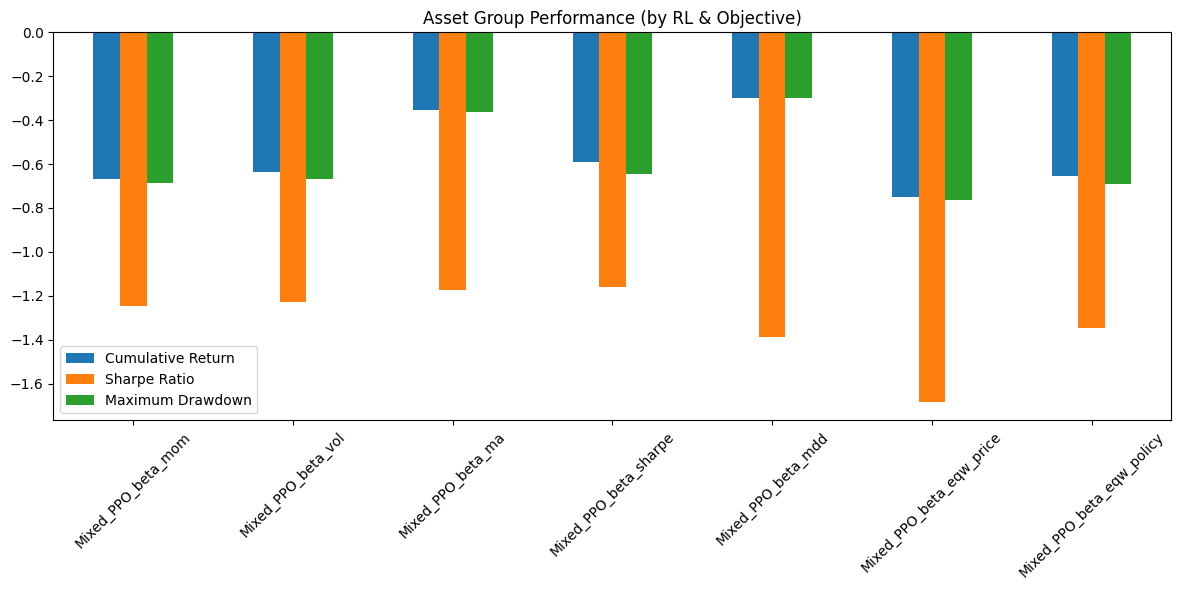

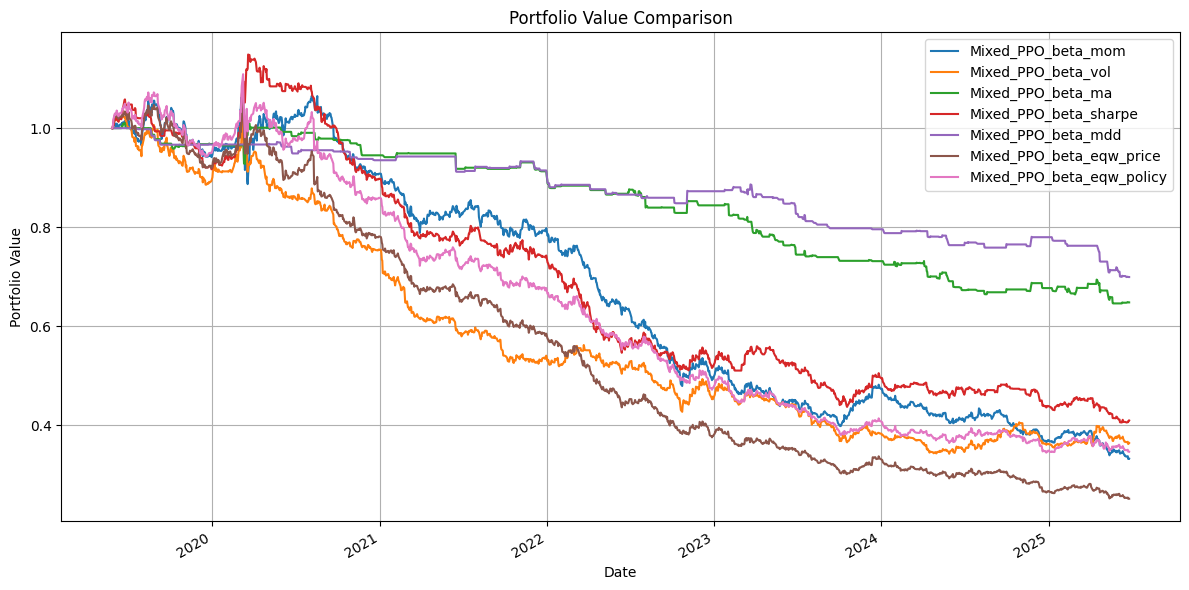

Empty DataFrame
Columns: []
Index: []


In [28]:
# 실험 실행
results = {}
previous_group = None

for group, assets, algo_name, algo_class, objective in experiments:
    key = f"{group}_{algo_name}_{objective}"
    print(f"▶ Running: {key}")
    try:
        results[key] = train_and_evaluate(assets, algo_class, objective)
    except Exception as e:
        print(f"Error in {key}: {str(e)}")
        results[key] = None
    # 그룹이 바뀔때만 기술통계 출력
    if previous_group != group:
        show_summary = True
        previous_group = group
    else:
        show_summary = False


# 성과 요약 (오류 제외)
valid_results = {k: v for k, v in results.items() if v is not None}
metrics_table = pd.DataFrame({k: performance_metrics(v) for k, v in valid_results.items()}).T
print(metrics_table)

# 성과 막대그래프
metrics_table[["Cumulative Return", "Sharpe Ratio", "Maximum Drawdown"]].plot(
    kind="bar", figsize=(12, 6), title="Asset Group Performance (by RL & Objective)"
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 포트폴리오 가치 시계열 그래프
results_df = pd.DataFrame(valid_results)
results_df.plot(figsize=(12, 6), title="Portfolio Value Comparison")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.tight_layout()
plt.show()



# sharpe 를 baseline으로 하여 통계적으로 의미가 있는지 비교함
summary = []

for (group, assets, algo, model_cls, obj) in experiments:
    if obj == "sharpe":
        continue  # baseline 제외

    base_key = f"{group}_{algo}_sharpe"
    compare_key = f"{group}_{algo}_{obj}"

    # Add check for None before calling compare_strategies
    if base_key in results and compare_key in results and results[base_key] is not None and results[compare_key] is not None:
        res = compare_strategies(results[base_key], results[compare_key], label1=base_key, label2=compare_key)
        summary.append({
            "Group": group,
            "Algorithm": algo,
            "CompareWith": obj,
            "t_p": res["t_p"],
            "u_p": res["u_p"]
        })

summary_df = pd.DataFrame(summary)
#import ace_tools as tools; tools.display_dataframe_to_user(name="Comparison Results", dataframe=summary_df)
print(summary_df)

In [29]:
멈춰

NameError: name '멈춰' is not defined

In [ ]:
# XAI (SHAP 해석) 함수 추가
import shap
from sklearn.ensemble import RandomForestRegressor


def run_shap_feature_importance_with_summary(factors, returns, target_asset="BTC-USD", sample_size=500):
    """
    SHAP 분석을 통해 각 팩터가 수익률에 미치는 영향을 시각화하고,
    Mean |SHAP value| 기준으로 수치 요약 결과를 반환
    """
    # 데이터 정리
    y = returns[target_asset].dropna()
    X = factors.loc[y.index].copy()
    X = X.dropna()
    y = y.loc[X.index]

    # 샘플 수 제한
    if sample_size is not None and len(X) > sample_size:
        X, _, y, _ = train_test_split(X, y, train_size=sample_size, random_state=42)

    # 모델 학습
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    # SHAP 계산
    explainer = shap.Explainer(model.predict, X)
    shap_values = explainer(X)

    # 시각화 (beeswarm 형식)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X, plot_type="dot", show=True)

    # 📊 평균 SHAP 값 계산 (논문용 해석)
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    shap_importance = pd.DataFrame({
        "Factor": X.columns,
        "Mean|SHAP|": mean_abs_shap
    }).sort_values(by="Mean|SHAP|", ascending=False).reset_index(drop=True)

    print("\n[SHAP 팩터 중요도 요약 (Mean Absolute SHAP Values)]")
    print(shap_importance.to_string(index=False))

    return shap_importance

In [ ]:
def run_shap_feature_importance(factors, returns, target_asset="BTC-USD", sample_size=1000):
    try:
        # 1. 대상 자산에 해당하는 팩터 컬럼 선택
        if isinstance(factors.columns[0], tuple):
            target_cols = [col for col in factors.columns if col[0] == target_asset]
        else:
            target_cols = [col for col in factors.columns if str(col).startswith(target_asset)]

        if not target_cols:
            print(f"[Error] {target_asset} 관련 팩터 컬럼이 없습니다.")
            return

        # 2. X, y 구성
        X = factors[target_cols].dropna()
        y = returns[target_asset].loc[X.index]

        # 3. X 컬럼 이름을 문자열로 변환 (중요!!)
        if isinstance(X.columns[0], tuple):
            X.columns = ['_'.join(col) for col in X.columns]

        # 4. 샘플 수 제한
        if sample_size and len(X) > sample_size:
            X, _, y, _ = train_test_split(X, y, train_size=sample_size, random_state=42)

        # 5. 모델 학습
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)

        # 6. SHAP 분석
        explainer = shap.Explainer(model, X)
        shap_values = explainer(X)

        # 7. SHAP summary plot
        shap.summary_plot(shap_values, X, plot_type="dot")

        # 8. 평균 SHAP 값 표 출력
        mean_shap = pd.DataFrame({
            "Factor": X.columns,
            "Mean |SHAP|": np.abs(shap_values.values).mean(axis=0)
        }).sort_values(by="Mean |SHAP|", ascending=False)

        print(mean_shap.round(4))
        return mean_shap

    except Exception as e:
        print(f"[오류] {target_asset}에 대한 SHAP 실행 실패: {e}")


In [ ]:
def run_shap_feature_importance_all_factors(factors, returns, target_asset, sample_size=1000):
    try:
        # 1. 모든 factor를 사용
        X = factors.dropna()
        y = returns[target_asset].loc[X.index]

        # 🔐 모든 컬럼 이름을 문자열로 변환 (중요!)
        X.columns = X.columns.map(str)

        # 2. 샘플 수 제한
        if sample_size and len(X) > sample_size:
            X, _, y, _ = train_test_split(X, y, train_size=sample_size, random_state=42)

        # 3. 모델 학습
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)

        # 4. SHAP 분석
        explainer = shap.Explainer(model, X)
        shap_values = explainer(X)

        # 5. 시각화
        shap.summary_plot(shap_values, X, plot_type="dot")

        # 6. 평균 SHAP값 테이블
        mean_shap = pd.DataFrame({
            "Factor": X.columns,
            "Mean |SHAP|": np.abs(shap_values.values).mean(axis=0)
        }).sort_values(by="Mean |SHAP|", ascending=False)

        print(mean_shap.round(4))
        return mean_shap

    except Exception as e:
        print(f"[오류] {target_asset}에 대한 SHAP 실행 실패: {e}")


In [ ]:
def run_shap_beta_feature_importance(factors, returns, target_asset, sample_size=1000):
    try:
        # 1. factor에서 dropna
        X = factors.dropna()

        # 2. 컬럼 이름 정리 (튜플 → 문자열)
        X.columns = [
            f"{col[0]}_{col[1]}" if isinstance(col, tuple) else str(col)
            for col in X.columns
        ]

        # 3. beta 관련 factor만 선택
        beta_columns = [col for col in X.columns if 'beta' in col.lower()]
        X = X[beta_columns]

        # ✅ returns와의 공통 인덱스 추출
        common_index = X.index.intersection(returns[target_asset].dropna().index)
        X = X.loc[common_index]
        y = returns[target_asset].loc[common_index]

        # 🔐 모든 컬럼 이름을 문자열로 변환
        X.columns = X.columns.map(str)

        # 2. 샘플 수 제한
        if sample_size and len(X) > sample_size:
            X, _, y, _ = train_test_split(X, y, train_size=sample_size, random_state=42)

        # 3. 모델 학습
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)

        # 4. SHAP 분석
        explainer = shap.Explainer(model, X)
        shap_values = explainer(X)

        # 5. 시각화
        shap.summary_plot(shap_values, X, plot_type="dot")

        # 6. 평균 SHAP값 정리
        mean_shap = pd.DataFrame({
            "Factor": X.columns,
            "Mean |SHAP|": np.abs(shap_values.values).mean(axis=0)
        }).sort_values(by="Mean |SHAP|", ascending=False)

        print(mean_shap.round(4))
        return mean_shap

    except Exception as e:
        print(f"[오류] {target_asset}에 대한 SHAP(beta) 실행 실패: {e}")


In [ ]:
price, returns, factors = fetch_data(mixed_assets)

for asset in mixed_assets:
    print(f"\n=== SHAP 분석 시작: {asset} ===")
    run_shap_feature_importance(factors=factors, returns=returns, target_asset=asset, sample_size=500)


In [ ]:
# 자산별 종가를 가져와서 price_df 생성
# 데이터 다운로드 (MultiIndex 처리)
raw_data = yf.download(mixed_assets, start=start_date, end=end_date, group_by='ticker' , auto_adjust=False)
price_df = raw_data.xs("Adj Close", axis=1, level=1)
price_df = price_df.dropna(how='all')

# 수익률 계산
returns_df = price_df.pct_change().dropna()

# SHAP 결과 저장용 딕셔너리 초기화
shap_results_all = {}

In [ ]:
# ▶ 평균 수익률이 가장 높은 모델 선택
mean_returns = {k: v.mean() for k, v in results.items()}
best_model_key = max(mean_returns, key=mean_returns.get)
print(f"\n✅ 수익률이 가장 높은 모델: {best_model_key}")

# ▶ 해당 모델만 SHAP 분석 수행
shap_results_all = {}

for asset in mixed_assets:
    try:
        print(f"[SHAP 실행] 모델={best_model_key}, 자산={asset}")
        shap_df = run_shap_beta_feature_importance(
            factors=factors,
            returns=returns_df,  # 종목별 수익률 DataFrame
            target_asset=asset,
            sample_size=500
        )
        shap_results_all[f"{best_model_key}_{asset}"] = shap_df
    except Exception as e:
        print(f"[오류] {asset}에 대한 SHAP 실행 실패: {e}")


In [ ]:
# 자산별 종가를 가져와서 price_df 생성
# 데이터 다운로드 (MultiIndex 처리)
raw_data = yf.download(mixed_assets, start="2018-01-01", end="2024-12-31", group_by='ticker' , auto_adjust=False)
price_df = raw_data.xs("Adj Close", axis=1, level=1)
price_df = price_df.dropna(how='all')

# 수익률 계산
returns_df = price_df.pct_change().dropna()

# SHAP 결과 저장용 딕셔너리 초기화
shap_results_all = {}

for model_key, portfolio_returns in results.items():
    for asset in mixed_assets:
        try:
            print(f"[asset=]{asset} [model_key=]{model_key}")
            shap_df = run_shap_beta_feature_importance(
                factors=factors,
                returns=returns_df,  # ✅ 반드시 종목별 수익률 DataFrame
                target_asset=asset,
                sample_size=500
            )
            shap_results_all[f"{model_key}_{asset}"] = shap_df
        except Exception as e:
            print(f"[오류] {asset}에 대한 SHAP 실행 실패: {e}")